Copyright Preferred Networks, Inc. as contributors to Matlantis contrib project

# Generate the liquid structure 
Atomic simulation with the liquid phase is complicated compared to solid materials. Solid materials usually have a clear and well-defined structure, which can be obtained experimentally. Liquid is formed by molecules. The position and orientation of each molecule are random in the liquid. To simulate a liquid phase, we need to spend more time preparing the initial structure. A standard method is to simulate the melting procedure: run high-temperature molecular dynamics from a solid phase until it reaches the liquid status. 
Here we proposed a new method by randomly put the molecule into a simulation box, and then optimize the initial guess of molecular position and orientation by minimizing the overlap among molecules using the backward function within PyTorch.


In [ ]:
!pip install pfp_api_client
!pip install ase matplotlib torch

# # 初回使用時のみ、ライブラリのインストールをお願いします。

In [1]:
from typing import List, Optional

import numpy as np
import torch
from ase import Atoms, units
from ase.data import atomic_masses
from torch import nn
from torch.optim.adam import Adam


class LiquidGenerator(nn.Module):
    def __init__(
        self, atoms_list: List[Atoms], cell: Optional[np.ndarray] = None, density: Optional[float] = 0.7, 
        cubic_cell: bool = True, wall:bool = False,
    ) -> None:
        """
        args:
            atoms_list (List[Atoms]): The atoms to be filled into the simulation box.
            cell (np.ndarray or None, optional): The cell shape of simulation box. Default to None.
            density (float or None, optional): Create the simulation box from the density. If the cell is provided, this parameter will be 
                ignored. Defalt to 0.7.
            cubic_cell (bool, optional): Create the cubic simulation box. If false, the cell length is allow to change (orthogonal cell). 
                Default to False.
            wall (bool, optional): Add additional constraints to refrine the molecule to cross the periodical boundary along z axis. This 
                can be used to generate a liquid / soild interface. Default to False
        """
        super(LiquidGenerator, self).__init__()
        self.mol = None
        self.density = density
        self.cubic_cell = cubic_cell
        self.idx = np.array(
            [i + 1 for i, a in enumerate(atoms_list) for j in range(len(a))]
        )
        self.num_of_mols = len(atoms_list)

        positions = np.vstack([a.get_positions() for a in atoms_list])
        self.register_buffer("positions", torch.tensor(positions, dtype=torch.float32))

        self.numbers = np.concatenate([a.get_atomic_numbers() for a in atoms_list])
        self.mass = atomic_masses[self.numbers].sum()
        
        if cell is None:
            self.length = (self.mass / units.kg / self.density * 1e27) ** (1 / 3.0)
            if self.cubic_cell:
                cell = torch.eye(3, dtype=torch.float32) * self.length
                self.register_buffer("_cell", cell)
            else:
                self.length_a = nn.Parameter(torch.tensor(self.length, dtype=torch.float32))
                self.length_b = nn.Parameter(torch.tensor(self.length, dtype=torch.float32))
        else:
            self.length = np.linalg.norm(cell, axis=1).mean()
            cell = torch.tensor(cell, dtype=torch.float32)
            self.register_buffer("_cell", cell)

        self.translation = nn.Parameter(torch.rand([self.num_of_mols, 3]) * self.length)
        self.rotation = nn.Parameter(torch.rand([self.num_of_mols, 3]) * np.pi)
        self.wall = wall

    def fit(self, epochs=50, lr=0.1):
        optimizer = Adam(self.parameters(), lr=0.1)
        print("step  score  cell_x  cell_y  cell_z")
        for i in range(epochs):
            optimizer.zero_grad()
            score = self.score()
            score.backward()
            optimizer.step()
            print(
                f" {i:3d} {score.item():10.2f}"
                f" {self.cell[0,0]:5.2f} {self.cell[1,1]:5.2f} {self.cell[2,2]:5.2f}"
            )

    @property
    def cell(self) -> None:
        if hasattr(self, "_cell"):
            return self._cell
        else:
            length_c = self.length ** 3 / self.length_a / self.length_b
            return torch.eye(
                3, device=self.length_a.device, dtype=torch.float32
            ) * torch.stack([self.length_a, self.length_b, length_c])

    def _generate(self) -> List[np.ndarray]:
        mol_positions = [
            self.positions[self.idx == i + 1] for i in range(self.num_of_mols)
        ]
        translation = torch.mm(torch.remainder(self.translation, 1), self.cell)  # wrap

        gen_positions = [
            translation_and_rotation(pos, vec, rot)
            for pos, vec, rot in zip(mol_positions, translation, self.rotation)
        ]
        return gen_positions

    def to_atoms(self) -> Atoms:
        gen_positions = self._generate()
        positions = np.empty([len(self.positions), 3])
        for i in range(self.num_of_mols):
            positions[self.idx == i + 1] = gen_positions[i].detach().cpu().numpy()
        atoms = Atoms(
            positions=positions,
            cell=self.cell.detach().cpu().numpy(),
            numbers=self.numbers,
            pbc=[1, 1, 1],
        )
        return atoms

    def score(self) -> float:
        dist = distance_matrix(self._generate(), self.cell)
        s = torch.sum((3.0 - dist[dist < 3.0]) ** 2)
        if self.wall:
            wdist = wall_dist(self._generate(), self.cell)
            s += 10 * torch.sum(wdist)**2
        return s
    

In [2]:
from torch import Tensor

def translation_and_rotation(positions: Tensor, vec: Tensor, rot: Tensor) -> Tensor:
    device = positions.device
    alpha, beta, gamma = rot

    rotation_x = torch.stack(
        [
            torch.tensor([1., 0., 0.], device=device),
            torch.stack([torch.tensor(0.0, device=device), torch.cos(alpha), -torch.sin(alpha)]),
            torch.stack([torch.tensor(0.0, device=device), torch.sin(alpha), torch.cos(alpha)]),
        ]
    )

    rotation_y = torch.stack(
        [
            torch.stack([torch.cos(beta), torch.tensor(0.0, device=device), -torch.sin(beta)]),
            torch.tensor([0.0, 1.0, 0.0], device=device),
            torch.stack([torch.sin(beta), torch.tensor(0.0, device=device), torch.cos(beta)]),
        ]
    )

    rotation_z = torch.stack(
        [
            torch.stack([torch.cos(gamma), -torch.sin(gamma), torch.tensor(0.0, device=device)]),
            torch.stack([torch.sin(gamma), torch.cos(gamma), torch.tensor(0.0, device=device)]),
            torch.tensor([0.0, 0.0, 1.0], device=device),
        ]
    )

    return torch.mm(
        torch.mm(torch.mm(positions, rotation_x), rotation_y), rotation_z
    ) + vec.view([1, 3])


def make_supercell(positions: Tensor, cell: Tensor) -> Tensor:
    device = positions.device
    vecs = torch.mm(
        torch.stack(torch.meshgrid([torch.tensor([-1.0, 0.0, 1.0], device=device)] * 3))
        .view([3, -1])
        .T,
        cell,
    )
    return (positions.unsqueeze(axis=0) + vecs.unsqueeze(axis=1)).view([-1, 3])


def distance_matrix(list_of_positions: List[Tensor], cell: Tensor) -> Tensor:
    positions = torch.cat(list_of_positions, axis=0)
    supercell = make_supercell(positions, cell)
    # TO FIX backward problem in torch.cdist in torch 1.5
    dist = torch.sqrt(
        torch.sum(
            torch.square(positions.unsqueeze(axis=1) - supercell.unsqueeze(axis=0)),
            axis=2,
        )
        + 1e-16
    )
    return dist

def wall_dist(list_of_positions: List[Tensor], cell: Tensor) -> Tensor:
    positions_z = torch.cat(list_of_positions, axis=0)[:,2]
    return torch.cat([-positions_z[positions_z < 0], positions_z[positions_z>cell[2,2]]-cell[2,2]])
    

In [3]:
from ase import Atoms
from rdkit import Chem
from rdkit.Chem import AllChem

def smiles_to_atoms(smiles: str) -> Atoms:
  mol = Chem.MolFromSmiles(smiles)
  mol = Chem.AddHs(mol)
  AllChem.EmbedMolecule(mol)
  atoms = Atoms(
      positions = mol.GetConformer().GetPositions(),
      numbers = np.array([a.GetAtomicNum() for a in mol.GetAtoms()])
  )
  return atoms

## Example 1
* We generate the mixture of two kind of molecules.
* We can set initial guess of density as 0.7 g/cm3.

In [4]:
atoms_mol_1 = smiles_to_atoms("CCCC(CCC)CCC(=O)O")
atoms_mol_2 = smiles_to_atoms("c1ccc(C)cc1")

atoms_list = [atoms_mol_1] * 5 + [atoms_mol_2] * 3
generator = LiquidGenerator(atoms_list, density=0.7)
generator.fit(epochs=100, lr=0.1)

atoms_mixture = generator.to_atoms()


step  score  cell_x  cell_y  cell_z
   0    4706.90 13.92 13.92 13.92
   1    4544.93 13.92 13.92 13.92
   2    4403.74 13.92 13.92 13.92
   3    4222.19 13.92 13.92 13.92
   4    4177.13 13.92 13.92 13.92
   5    4148.86 13.92 13.92 13.92
   6    4091.17 13.92 13.92 13.92
   7    4012.30 13.92 13.92 13.92
   8    4003.91 13.92 13.92 13.92
   9    3970.52 13.92 13.92 13.92
  10    3945.15 13.92 13.92 13.92
  11    3966.13 13.92 13.92 13.92
  12    3961.27 13.92 13.92 13.92
  13    3940.00 13.92 13.92 13.92
  14    3923.20 13.92 13.92 13.92
  15    3903.97 13.92 13.92 13.92
  16    3885.64 13.92 13.92 13.92
  17    3885.33 13.92 13.92 13.92
  18    3895.37 13.92 13.92 13.92
  19    3894.15 13.92 13.92 13.92
  20    3880.65 13.92 13.92 13.92
  21    3868.64 13.92 13.92 13.92
  22    3863.88 13.92 13.92 13.92
  23    3863.83 13.92 13.92 13.92
  24    3865.55 13.92 13.92 13.92
  25    3865.66 13.92 13.92 13.92
  26    3864.62 13.92 13.92 13.92
  27    3862.31 13.92 13.92 13.92
  28    3858

* view of the generated structure.

In [5]:
from ase.visualize import view
view(atoms_mixture, viewer="ngl")

## Example 2
* Generate a liquid structure of ethylene carbonate (EC).
* We can set the `wall=True` so that the generated structure can be directly stacked to the slab to make a liquid/solid structure.

In [6]:
atoms_mol_ec = smiles_to_atoms("C1COC(=O)O1")

atoms_list = [atoms_mol_ec] * 50
generator = LiquidGenerator(atoms_list, cell = [[22.17486865801013, 0.0, 0.0], [11.087434329005065, 19.203999583420114, 0.0], [0.0, 0.0, 9.0]], wall=True)
generator.fit()

atoms = generator.to_atoms()

step  score  cell_x  cell_y  cell_z
   0   26000.95 22.17 19.20  9.00
   1   14871.46 22.17 19.20  9.00
   2   14921.08 22.17 19.20  9.00
   3   14714.07 22.17 19.20  9.00
   4   13724.31 22.17 19.20  9.00
   5   13542.29 22.17 19.20  9.00
   6   12946.75 22.17 19.20  9.00
   7   12676.95 22.17 19.20  9.00
   8   12621.05 22.17 19.20  9.00
   9   12347.27 22.17 19.20  9.00
  10   12347.55 22.17 19.20  9.00
  11   11917.09 22.17 19.20  9.00
  12   11808.87 22.17 19.20  9.00
  13   11707.11 22.17 19.20  9.00
  14   11373.92 22.17 19.20  9.00
  15   11378.53 22.17 19.20  9.00
  16   11296.46 22.17 19.20  9.00
  17   11109.66 22.17 19.20  9.00
  18   10927.98 22.17 19.20  9.00
  19   10762.53 22.17 19.20  9.00
  20   10765.41 22.17 19.20  9.00
  21   10701.62 22.17 19.20  9.00
  22   10562.56 22.17 19.20  9.00
  23   10465.88 22.17 19.20  9.00
  24   10396.75 22.17 19.20  9.00
  25   10358.52 22.17 19.20  9.00
  26   10295.70 22.17 19.20  9.00
  27   10252.50 22.17 19.20  9.00
  28   10212

* view of the generated structure.

In [7]:
from ase.visualize import view
view(atoms, viewer="ngl")

* stack the EC to the Pt (111) slab.

In [8]:
from ase.build import fcc111
from ase.build.tools import stack

slab = fcc111("Pt", size=(8,8,5), vacuum=2.0)
surface = stack(atoms, slab)

* view of the generated structure.

In [9]:
view(surface, viewer="ngl")

## Relaxation after structure generation

Once structure is geneated, it is common practice to further relax the structure before main simulation.<br/>
Here, we proceed with 1. FIRE relaxation and 2. NPT relaxation.<br/>

For 1. it is necessary to avoid big force in atoms, but we apply a loose force convergence (fmax=0.2) here. For 2., it is useful to let atoms align to specific orientation etc.

### 1. FIRE relaxation

Here we optimize both position and cell of atoms. <br/>
`ExpCellFilter` is used to optimize cell, and `hydrostatic_strain=True` is used to keep cell length ratio.

In [ ]:
!pip install pfp-api-client

In [10]:
from ase.optimize import FIRE
from ase.constraints import ExpCellFilter

from pfp_api_client.pfp.calculators.ase_calculator import ASECalculator
from pfp_api_client.pfp.estimator import Estimator

atoms = atoms_mixture.copy()

estimator = Estimator()
calculator = ASECalculator(estimator)
atoms.calc = calculator

atoms_ecf = ExpCellFilter(atoms, hydrostatic_strain=True)
opt = FIRE(atoms_ecf)
opt.run(fmax=0.2)

      Step     Time          Energy         fmax
*Force-consistent energies used in optimization.
FIRE:    0 06:22:38     -908.994592*      15.4019
FIRE:    1 06:22:38     -876.603539*     260.0209
FIRE:    2 06:22:38     -905.580940*     127.6730
FIRE:    3 06:22:39     -899.513803*     161.9644
FIRE:    4 06:22:39     -908.882040*      80.6560
FIRE:    5 06:22:39     -910.409143*      59.5212
FIRE:    6 06:22:40     -910.799287*      50.2485
FIRE:    7 06:22:40     -911.350695*      33.3635
FIRE:    8 06:22:40     -911.748572*      11.8129
FIRE:    9 06:22:41     -911.788821*      10.5736
FIRE:   10 06:22:41     -911.793758*      10.1856
FIRE:   11 06:22:41     -911.803182*       9.4237
FIRE:   12 06:22:42     -911.816199*       8.3159
FIRE:   13 06:22:42     -911.831637*       6.9066
FIRE:   14 06:22:42     -911.848246*       5.2557
FIRE:   15 06:22:42     -911.864932*       3.4423
FIRE:   16 06:22:43     -911.880891*       2.2492
FIRE:   17 06:22:43     -911.897509*       2.2390
FI

True

You can see cell length has changed, but its shape is kept cubic.

In [11]:
print(f"Before: {atoms_mixture.cell}")
print(f"After : {atoms.cell}")

Before: Cell([13.923047065734863, 13.923047065734863, 13.923047065734863])
After : Cell([14.132228031737046, 14.132228031737046, 14.132228031737046])


In [12]:
# View structure after relaxation
from ase.visualize import view
view(atoms, viewer="ngl")

### 2. NPT relaxation

Please change `target_temp`, `target_pressure` and `steps` based on your problem.<br/>
Run longer `steps` for more relaxation (this is demo so small value is used, but please increase this value in your real problem).

In [13]:
from ase.md.velocitydistribution import MaxwellBoltzmannDistribution, Stationary
from ase.md.verlet import VelocityVerlet
from ase.md.npt import NPT
from ase.md.nptberendsen import NPTBerendsen
from ase.md.nvtberendsen import NVTBerendsen
from ase.io import Trajectory
from ase import units

from pfp_api_client.pfp.estimator import Estimator
from pfp_api_client.pfp.calculators.ase_calculator import ASECalculator

from time import perf_counter
import numpy as np
import os


os.makedirs("output", exist_ok=True)

# --- parameters ----
# Please change based on configuration
target_temp = 300
target_pressure = 101325 * units.Pascal
steps = 100
# ------------------

MaxwellBoltzmannDistribution(
    atoms,
    temperature_K=target_temp
)
Stationary(atoms)
dyn = NPT(
    atoms,
    1.0 * units.fs,
    temperature_K=target_temp,
    externalstress=target_pressure,
    mask=np.eye(3),
    ttime=10 * units.fs,
    pfactor=100 * units.fs,
    logfile="output/md.log",
    trajectory="output/md.traj"
)

start_time = perf_counter()

def print_dyn():
    print(f"Dyn  step: {dyn.get_number_of_steps(): >3}, E_tot: {atoms.get_total_energy():.3f}, ",
          f"E_pot: {atoms.get_potential_energy():.3f}, ",
          f"density: {atoms.get_global_number_of_atoms() / atoms.get_volume():.3f}, ",
          f"T: {atoms.get_temperature():.1f}K, elapsed_time: {perf_counter() - start_time:.2f} sec")

dyn.attach(print_dyn, interval=10)
dyn.run(steps)

Dyn  step:  10, E_tot: -906.718,  E_pot: -912.444,  density: 0.073,  T: 216.1K, elapsed_time: 1.37 sec
Dyn  step:  20, E_tot: -900.497,  E_pot: -909.109,  density: 0.073,  T: 325.0K, elapsed_time: 2.61 sec
Dyn  step:  30, E_tot: -897.640,  E_pot: -908.140,  density: 0.073,  T: 396.3K, elapsed_time: 3.94 sec
Dyn  step:  40, E_tot: -903.022,  E_pot: -910.413,  density: 0.073,  T: 278.9K, elapsed_time: 5.14 sec
Dyn  step:  50, E_tot: -906.466,  E_pot: -912.674,  density: 0.073,  T: 234.3K, elapsed_time: 6.61 sec
Dyn  step:  60, E_tot: -906.439,  E_pot: -912.398,  density: 0.073,  T: 224.9K, elapsed_time: 8.01 sec
Dyn  step:  70, E_tot: -902.962,  E_pot: -910.787,  density: 0.073,  T: 295.3K, elapsed_time: 9.36 sec
Dyn  step:  80, E_tot: -898.511,  E_pot: -909.626,  density: 0.073,  T: 419.5K, elapsed_time: 10.67 sec
Dyn  step:  90, E_tot: -899.581,  E_pot: -909.164,  density: 0.073,  T: 361.7K, elapsed_time: 11.70 sec
Dyn  step: 100, E_tot: -903.858,  E_pot: -910.639,  density: 0.073,  T:

In [14]:
# View NPT relaxation
from ase.io import Trajectory
from ase.visualize import view

traj = Trajectory("output/md.traj")
view(traj, viewer="ngl")

Plot potential temperature, energy and density.

Please increase NPT `steps` if these values are not converged.

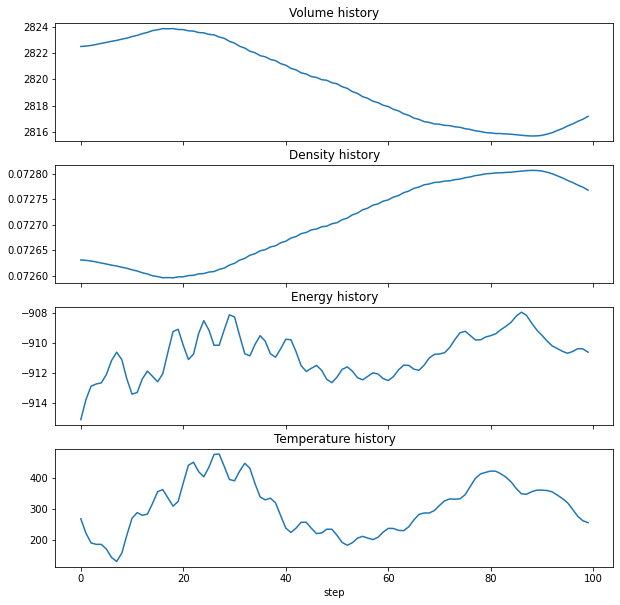

In [15]:
import matplotlib.pyplot as plt

volume_list = [atoms.get_volume() for atoms in traj]
density_list = [atoms.get_global_number_of_atoms() / atoms.get_volume() for atoms in traj]
energy_list = [atoms.get_potential_energy() for atoms in traj]
temperature_list = [atoms.get_temperature() for atoms in traj]

fig, axes = plt.subplots(4, 1, sharex=True, figsize=(10, 10))

axes[0].plot(volume_list)
axes[0].set_title("Volume history")

axes[1].plot(density_list)
axes[1].set_title("Density history")

axes[2].plot(energy_list)
axes[2].set_title("Energy history")

axes[3].plot(temperature_list)
axes[3].set_title("Temperature history")
axes[3].set_xlabel("step")

fig.savefig("output/md_stats_history.png")